# **使用PyTorch复现RCAN图像超分辨率**
**一种单图像超分辨率（single image super-resolution）模型，由一幅低分辨率图像恢复出高分辨率图像。**  
  
**本教程数据集为DIV2K，使用彩图训练，缩放倍数为4。可改为其他缩放倍数自行训练。**

## 1. ~~Introduction~~简介
![](https://ai-studio-static-online.cdn.bcebos.com/67d8a4d807c74145b2a13475b75ae3e167871cfb5bb14518ae9aae758f5b8708)  
图像超分辨率（SR），顾名思义，就是提高图像的分辨率。嗯。。这次是要复现一个超分模型**RCAN**（Image Super-Resolution Using Very Deep Residual Channel Attention Networks），用一个网络学习低分辨率（LR）图像到高分辨率（HR）图像的映射。传送门→[https://openaccess.thecvf.com/content_ECCV_2018/papers/Yulun_Zhang_Image_Super-Resolution_Using_ECCV_2018_paper.pdf](https://openaccess.thecvf.com/content_ECCV_2018/papers/Yulun_Zhang_Image_Super-Resolution_Using_ECCV_2018_paper.pdf). 为何选这篇？因为它够简单，我够懒。话不多说，来捋一遍↓↓↓

In [16]:
import torch as T 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader  
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2  
import random  
import time  

In [17]:
scale = 3
patch_size = [48, 48]  
path_train = 'E:/data/DIV2K/DIV2K_train_HR/'  
path_test = 'E:/data/DIV2K/DIV2K_train_HR/'  
path_model = 'D:/model/rcan/model/'
image_channel = 1
device = T.device("cuda:0") if T.cuda.is_available() else T.device("cpu")
num_workers = 0
batch_size = 16

## 2. 数据
使用**DIV2K**数据集，其中有800张图像。训练超分模型时，人们流行将一张图像切分为多张小图像来训练。下面的读写数据函数，每次读取一张图像（HWC），返回batchsize对LR/HR图像（NCHW），其中LR图像高宽为PATCHSIZE，HR图像高宽为PATCHSIZE×SCALE。

In [18]:
class Dataset_(Dataset):
    #
    def __init__(self, path=path_train, image_channel=image_channel, scale=scale, patch_size=patch_size, batch_size=batch_size):
        self.path = path
        self.list_image = os.listdir(path)
        if image_channel == 1:
            self.color_mode = 0
        else:
            self.color_mode = 1
        self.scale = scale
        self.patch_size = patch_size
        self.batch_size = batch_size
    #
    def __getitem__(self, idx):
        #
        image_hr = cv2.imread(self.path+self.list_image[idx//self.batch_size], self.color_mode)
        #
        image_hr = self.adjust_hr(image_hr)
        image_lr = cv2.resize(image_hr, dsize=(image_hr.shape[1]//self.scale, image_hr.shape[0]//self.scale), interpolation=cv2.INTER_CUBIC)
        #
        image_lr, image_hr = self.get_patch(image_lr, image_hr)
        #
        image_lr = image_lr.reshape([*image_lr.shape[:2],-1])
        image_hr = image_hr.reshape([*image_hr.shape[:2],-1])
        #
        image_lr, image_hr = self.data_augmentation(image_lr, image_hr)
        #
        image_lr = image_lr.transpose([2, 0, 1]).astype(np.float32) / 255.0
        image_hr = image_hr.transpose([2, 0, 1]).astype(np.float32) / 255.0
        return image_lr, image_hr
    #
    def __len__(self):
        return len(self.list_image) * self.batch_size
    #
    def adjust_hr(self, image_hr):
        h, w = image_hr.shape[:2]
        h_adjust = h // (self.scale*self.patch_size[0]) * self.scale * self.patch_size[0]
        w_adjust = w // (self.scale*self.patch_size[1]) * self.scale * self.patch_size[1]
        h_min = random.randint(0, h-h_adjust)
        w_min = random.randint(0, w-w_adjust)
        image_hr = image_hr[h_min:h_min+h_adjust, w_min:w_min+w_adjust, ...]
        return image_hr
    #
    def get_patch(self, image_lr, image_hr):
        h_min, w_min = random.randint(0, image_lr.shape[0]-self.patch_size[0]), random.randint(0, image_lr.shape[1]-self.patch_size[1])
        image_lr_patch = image_lr[h_min:h_min+self.patch_size[0], w_min:w_min+self.patch_size[1], ...]
        image_hr_patch = image_hr[self.scale*h_min:self.scale*(h_min+self.patch_size[0]), self.scale*w_min:self.scale*(w_min+self.patch_size[1]), ...]
        return image_lr_patch, image_hr_patch
    #
    def data_augmentation(self, image_lr, image_hr): 
        if random.randint(0, 1):
            image_lr = image_lr[::-1, :, ...]
            image_hr = image_hr[::-1, :, ...]
        if random.randint(0, 1):
            image_lr = image_lr[:, ::-1, ...]
            image_hr = image_hr[:, ::-1, ...]
        if random.randint(0, 1):
            image_lr = image_lr.transpose([1, 0, 2])
            image_hr = image_hr.transpose([1, 0, 2])
        return image_lr.copy(), image_hr.copy()

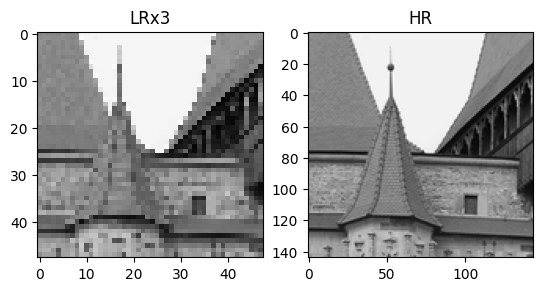

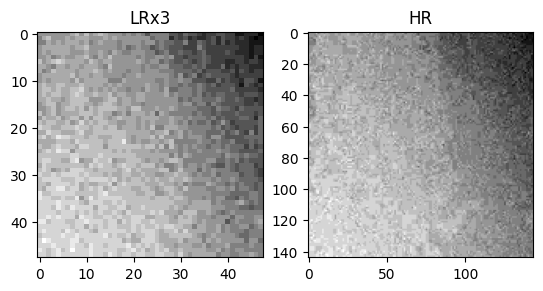

In [19]:
dataloader = DataLoader(Dataset_(), batch_size=1, shuffle=True)

for n, (image_lr, image_hr) in enumerate(dataloader):
    image_lr = image_lr.permute([0, 2, 3, 1]).squeeze().numpy()
    image_hr = image_hr.permute([0, 2, 3, 1]).squeeze().numpy()
    plt.subplot(1, 2, 1), plt.imshow(image_lr, 'gray'), plt.title('LRx'+ str(scale))
    plt.subplot(1, 2, 2), plt.imshow(image_hr, 'gray'), plt.title('HR')
    plt.show()
    if n == 1:
        break

## 3. 网络结构
下面开始搭积木环节，整体框架如下图所示：
![](https://ai-studio-static-online.cdn.bcebos.com/610995499bf44ed79d4ce744178e79d35a58414d4a0a4842807fa6994bf7a600)  
RCAN主要由四部分组成：浅特征提取、Residual in Residual (RIR)深度特征提取、上采样模块和重建部分。假设$I_{LR}$和$I_{SR}$表示为RCAN的输入和输出。  
1.浅特征提取：仅使用一个卷积层（conv）从$I_{LR}$输入中提取浅特征$F_0$（其中$H_{SF}$表示卷积运算，$F_0$用于RIR模块的深度特征提取）：  
![](https://ai-studio-static-online.cdn.bcebos.com/8bb2e0838b344682854ccd61decb8e83ba5574d80b304a6b9ec518b2892216e5)  
2.Residual in Residual(RIR)深度特征提取（$H_{RIR}$表示的是RIR模块，包括G个残差组RG）:    
![](https://ai-studio-static-online.cdn.bcebos.com/77d540ccfb6c4dd596624aa37439d222a0f5a76655704bf4a77339a39f05e3aa)  
3.上采样模块（$H_{UP}$表示上采样的算法,这里用的是pixel shuffle；$F_{UP}$表示上采样之后得到的特征图）：  
![](https://ai-studio-static-online.cdn.bcebos.com/a09af0f056664d91bc1def709caac23316788446c52143a187f4eb980117e9ea)  
4.重建，通过一个卷积层重建升级的特征：  
![](https://ai-studio-static-online.cdn.bcebos.com/bc9d9b9445584b6187d5db5963907b319d0d452d377f49a2903ed885c42068bd)  
浅特征提取、上采样、重建都很简单直观，下面着重看一下RIR模块，它包含G个residual groups（RG）和一个卷积层和一个 long skip connection（LSC）。

In [20]:
class RCAN(nn.Module):

    def __init__(self, channel=64, reduction=16, numRG=2, numRCAB=4, scale=scale):
        super(RCAN, self).__init__()
        self.conv1 = nn.Conv2d(image_channel,channel,3,padding=1)
        self.RG_list = nn.ModuleList()
        for _ in range(numRG):
            self.RG_list.append(RG(channel, reduction,numRCAB))
        self.conv2= nn.Conv2d(channel,channel,3,padding=1)
        self.upsampler = nn.ModuleList()
        while scale // 2 >= 1:
            if scale // 2 > 1:
                scale_ = scale // 2
            else:
                scale_ = scale
            self.upsampler.append(nn.Conv2d(channel, channel*scale_**2, 3, padding=1))
            self.upsampler.append(nn.PixelShuffle(scale_))
            scale //= 2
        self.upsampler.append(nn.Conv2d(channel,image_channel,3,padding=1))

    def forward(self, x):
        x = self.conv1(x)
        y = x
        for rg in self.RG_list:
            y = rg(y)
        y = self.conv2(y)
        y = x + y
        for layer in self.upsampler:
            y = layer(y)
        return y

然后，宛如套娃一般，RG模块又由B个residual channel attention blocks(RCAB)、一个卷积层和一个short skip connection(SSC)组成。咦？我为什么要说又？

In [21]:
class RG(nn.Module):

    def __init__(self, channel, reduction, numRCAB):
        super(RG,self).__init__()
        self.RCAB_list = nn.ModuleList()
        for i in range(numRCAB):
            self.RCAB_list.append(RCAB(channel, reduction))
        self.conv = nn.Conv2d(channel,channel,3,padding=1)

    def forward(self, x):
        y = x
        for rcab in self.RCAB_list:
            y = rcab(y)
        y = self.conv(y) 
        return x + y

那，这个RCAB又是什么玩意？  
![](https://ai-studio-static-online.cdn.bcebos.com/910bf7da68a34bf082e608d5af61320fb44938d2296943dea7ee407a482909d6)  
哦。是把原始的残差块里的第二个relu用一个通道注意力模块代替。  

In [22]:
class RCAB(nn.Module):

    def __init__(self, channel, reduction):
        super(RCAB, self).__init__()
        self.conv1 = nn.Conv2d(channel,channel,3,padding=1)
        self.conv2 = nn.Conv2d(channel,channel,3,padding=1)
        self.ca = CA(channel, reduction)

    def forward(self,  x):
        y = self.conv1(x)
        y = F.relu(y)
        y = self.conv2(y)
        y = self.ca(y)
        return x + y

最后，通道注意力模块是SENet中提出的Squeeze-and-Excitation(SE)模块。  
它计算特征图每个通道的平均值，经过两层全连接变换为特征图通道的重要性，在通道这个维度将特征图加权调整。
![](https://ai-studio-static-online.cdn.bcebos.com/f128cbaf3bc34fe6a9118a4363e59683dcca2bacdaaa4a3ab793b2cefb435901)  
至此，积木搭建完毕。

In [23]:
class CA(nn.Module):

    def __init__(self, channel, reduction):
        super(CA, self).__init__()
        self.conv1 = nn.Conv2d(channel,channel//reduction,1)
        self.conv2 = nn.Conv2d(channel//reduction,channel,1)

    def forward(self, x):
        means = T.mean(x, [2,3], True)
        y = self.conv1(means)
        y = F.relu(y)
        y = self.conv2(y)
        y = F.sigmoid(y)
        return x * y

## 4. 看一下效果
HR图像下采样得到一张LR图像，把LR输入网络中，得到SR图像，我希望它更接近HR↓巴啦啦能量，变！

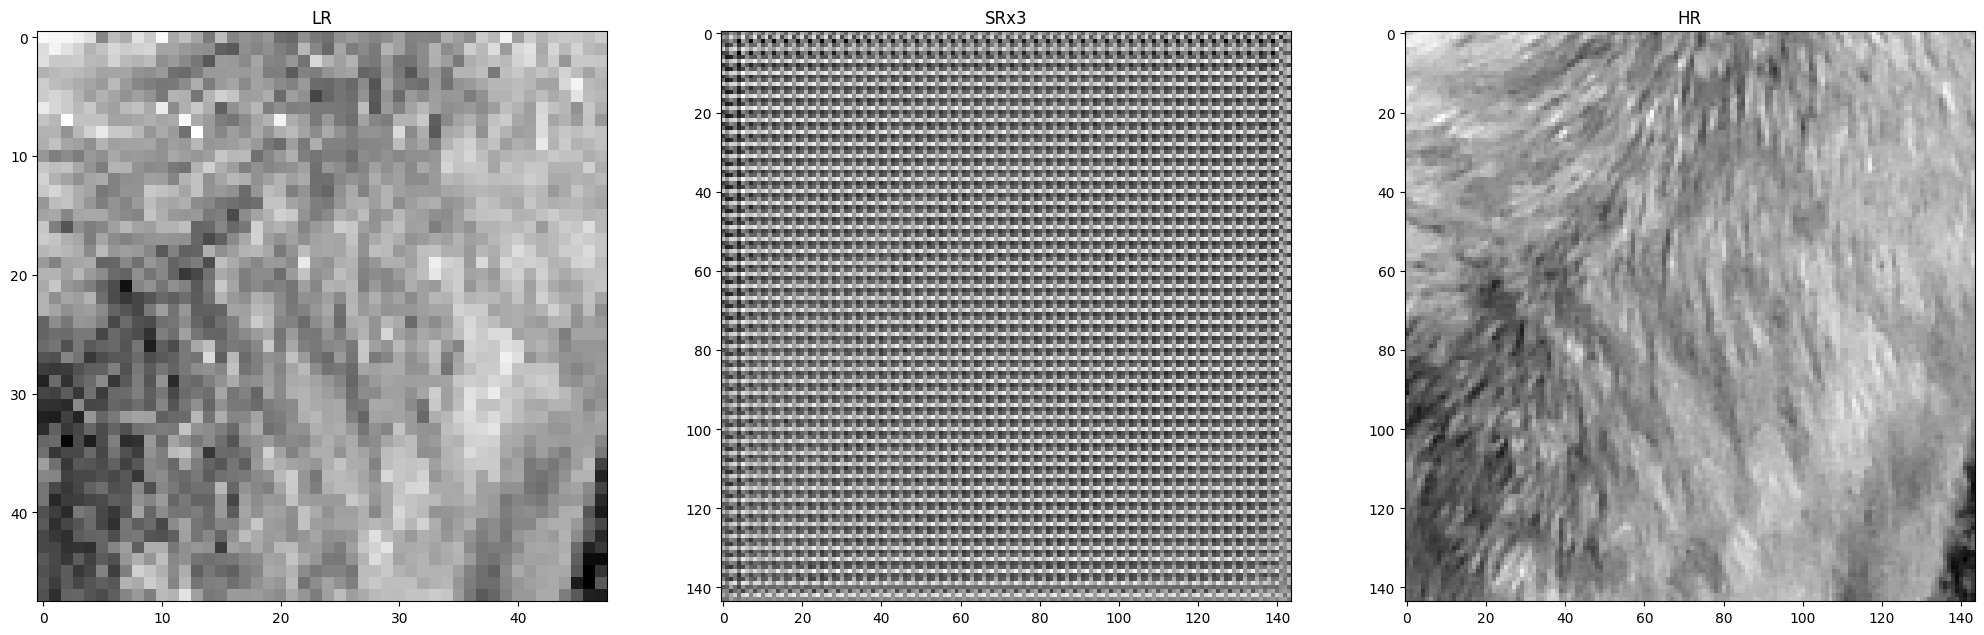

In [24]:
def show_image(net=None):
    #
    if net==None:
        net = RCAN().to(device)
    net.eval()
    #
    fig = plt.figure(figsize=(25, 25))
    gs = plt.GridSpec(1, 3)
    gs.update(wspace=0.1, hspace=0.1)
    #
    dataloader = DataLoader(Dataset_(path=path_test), batch_size=1, shuffle=True, num_workers=0)
    for image_lr, image_hr in dataloader:
        image_sr = net(image_lr.to(device)).permute([0, 2, 3, 1]).squeeze().cpu().detach().numpy()
        image_lr = image_lr.permute([0, 2, 3, 1]).squeeze().numpy()
        image_hr = image_hr.permute([0, 2, 3, 1]).squeeze().numpy()
        plt.subplot(1, 3, 1), plt.imshow(image_lr, 'gray'), plt.title('LR')
        plt.subplot(1, 3, 2), plt.imshow(image_sr, 'gray'), plt.title('SRx'+ str(scale))
        plt.subplot(1, 3, 3), plt.imshow(image_hr, 'gray'), plt.title('HR')
        plt.show()
        break

show_image()

嗯？？怎么是一片雪花？哦。。还没训练。。
## 5. 训练
原论文中，RG的数量是10，每个RG中有20个RCAB。patch size为48×48，批大小为16。初始学习率为$10^{-4}$，每$2×10^{5}$次迭代减半。我滴个鬼鬼，DIV2K有800张图，$2×10^{5}/800=250$，那帮人不知道训练了多少个250epoch，真的有设备任性啊。。。

In [25]:
def train(epoch_num, load_model, batch_size):
    #
    net = RCAN().to(device)
    net.train()
    optimizer = T.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.999))
    dataloader = DataLoader(Dataset_(), batch_size=batch_size, shuffle=True, num_workers=num_workers)
    if load_model == True:
        net.load_state_dict(T.load(path_model+'net.pt'))
        optimizer.load_state_dict(T.load(path_model+'optimizer.pt'))
        with open(path_model+'epoch.txt', 'r') as f:
            epoch_start = int(f.read())
    else:
        epoch_start = -1
    #
    iteration_num = 0
    time_start = time.time()
    for epoch in range(epoch_start+1, epoch_num):
        for image_lr, image_hr in dataloader:
            iteration_num += 1      
            image_lr = image_lr.to(device)
            image_hr = image_hr.to(device)
            image_sr = net(image_lr) 
            optimizer.zero_grad()
            loss = T.mean(T.abs(image_sr - image_hr))
            loss.backward()
            optimizer.step()
        #
        if(epoch % 1 == 0):
            print('Epoch: ', epoch, ', Iteration: ', iteration_num, ', Loss: ', loss.item(), ', Time: ', time.time() - time_start)
            T.save(net.state_dict(), path_model+'net.pt')
            T.save(optimizer.state_dict(), path_model+'optimizer.pt')
            with open(path_model+'epoch.txt', 'w') as f:
                f.write(str(epoch))
            show_image(net)                         
            time_start = time.time()

In [26]:
# train(epoch_num=1, load_model=False, batch_size=batch_size)  #第一个epoch，保存模型， 记得注释

In [27]:
train(epoch_num=200, load_model=True, batch_size=batch_size)  #后面每次训练就可以读取之前的模型，继续训练了

## 6. 真·看一下效果


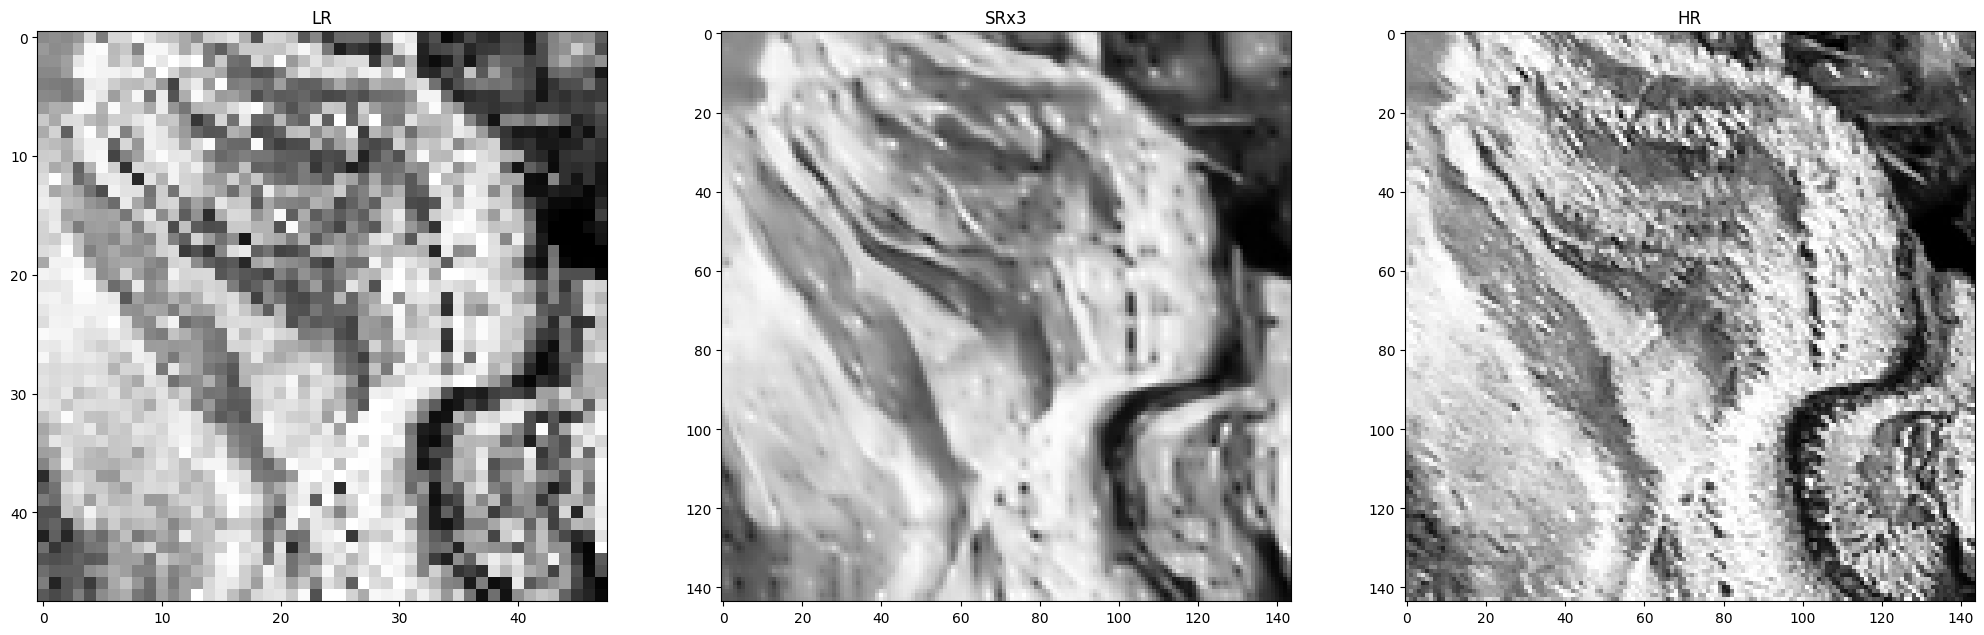

In [48]:
net = RCAN().to(device)
net.eval()
net.load_state_dict(T.load(path_model+'net.pt'))
show_image(net)

# 导出onnx

In [29]:
# net = RCAN().to(device)
# net.eval()
# net.load_state_dict(T.load(model_path+'net.pt'))
# net.half()

# T.onnx.export(net, T.randn([1, 1, 1024, 1024], dtype=T.float16, device=device), model_path+'RCAN.onnx', input_names=['input'], output_names=['output'])


## 7. 总结与展望
RCAN是行业出名的方法。但是，但是，但是，这种直接将LR映射为HR的方式，真的好吗？不好意思，RCAN，我不是针对你，而是说，所有此类方法，都是辣鸡。  
为何？因为超分辨率是一个ill-posed问题。不同的HR图像下采样可能得到同一个LR，也就是说，一个LR可能映射为{$HR_1,HR_2,HR_3$......}中的任一个。但是你的LR-HR训练数据中，这个LR与$HR_{250}$配对，那个LR与$HR_{998}$配对，又没有额外的条件控制谁和谁配对。然后网络就蒙圈了：  
你到底要我干啥？一会这样一会那样。我给你平均一下行了吧。。。